In [153]:
# import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report
import seaborn as sns


# Analysing the 'Hausfrauenhoch'

## Overview

![AI Rendering of a cliché housewife trading](image.png "Image generated with https://huggingface.co/spaces/black-forest-labs/FLUX.1-dev")

Explanation from ChatGPT:

> The German term **"Hausfrauenhoch"** refers to a phenomenon in the stock market where even inexperienced investors (often retail or small-scale private investors) start investing during a market phase characterized by significant price increases. This behavior typically occurs in the later stages of a bull market, just before a market correction or crash. The term alludes to the idea that even less knowledgeable investors (such as housewives, according to the cliché) begin to invest in the stock market because they believe that profits are "guaranteed."
> 
> There isn't a direct equivalent term in English, but there are similar terms and phrases that can describe the concept. Examples include:
> 
> 1. **Late-stage bull market rally**  
>    Refers to the late phase of a bull market, where prices often continue to rise without fundamental justification, driven by optimism and speculation.
> 
> 2. **Retail investor frenzy**  
>    Describes the behavior of retail investors entering the market in large numbers, often without deep knowledge or expertise.
> 
> 3. **Market euphoria** or **irrational exuberance**  
>    These terms describe the over-the-top enthusiasm and often irrational overvaluation of markets.
> 
> 4. **FOMO buying** (Fear of Missing Out)  
>    Refers to the phenomenon where investors buy into the market out of fear of missing the rally, which further drives prices higher.
> 
> While none of these terms captures the exact nuance of *"Hausfrauenhoch,"* they can be used to describe the broader phenomenon in English.


## Accessing the python code

This notebook is rendered in two versions:

* just the explanations and results visible at [https://michael-zeller.github.io/udacity_cd1971/]
* the complete notebook with the code visible at [https://michael-zeller.github.io/udacity_cd1971/fomo_btc.html]

## Problem Statement & Used Metrics

We want to optimize our Bitcoin investments by using public available data on the generel inerest in bitcoin.

If we could predict the bitcoin price of the (near) future we could sell or buy accordingly.

We will use historical data from Google Trends and Bitcoinity to train a RandomForestRegressor model to predict the price of Bitcoin one week in advance. By analyzing the model's predictions, we can make informed investment decisions, buying Bitcoin when the price is expected to rise and shorting it when the price is expected to fall. 

As the predicted price of bitcoin changed a lot over the course of the last years, the Mean Squared Error is not feasibly for evaluating the trained model. We will use Mean Absolute Percentage Error (MAPE) and R^2 score to measure the performance of our model. 

To get some hands-on-values we will test our strategy by simulating weekly investments based on the model's predictions.

## Used data

As an indicator for the overall interest in bitcoin and crypto investment we use data from google trends. You can access this data under [Google Trends for bitcoin,investment,inflation,economy,crypto](https://trends.google.de/trends/explore?date=2020-01-01%202025-01-01&q=bitcoin,investment,inflation,economy,crypto&hl=de).

Bitcoin relevant information is retrieved from [Bitcoinity Price and Volume](https://data.bitcoinity.org/markets/price_volume/5y/USD?r=week&t=lb&vu=curr)

Both datasets have a horizon from 5 years and a weekly resolution.

In [154]:
# load data

price_vol_usd_btc = pd.read_csv('data/bitcoinity_price_volume_USD_btc_5y.csv')    # price and volume in USD
google_trends = pd.read_csv('data/googleTrends_5y.csv')





## Data Exploration



### Bitcoin Price and Volume

                      Time        price        volume
0  2019-12-30 00:00:00 UTC  7292.709828  1.127543e+09
1  2020-01-06 00:00:00 UTC  7991.059379  2.185377e+09
2  2020-01-13 00:00:00 UTC  8698.438710  2.532033e+09
3  2020-01-20 00:00:00 UTC  8538.308612  1.355440e+09
4  2020-01-27 00:00:00 UTC  9235.803210  2.067519e+09
               price        volume
count     261.000000  2.610000e+02
mean    36382.593201  6.951969e+09
std     21078.936304  4.925549e+09
min      5757.424605  1.127543e+09
25%     20182.601795  3.630838e+09
50%     32407.464415  5.572479e+09
75%     51022.430318  8.678836e+09
max    101064.220105  3.253702e+10
Time      0
price     0
volume    0
dtype: int64


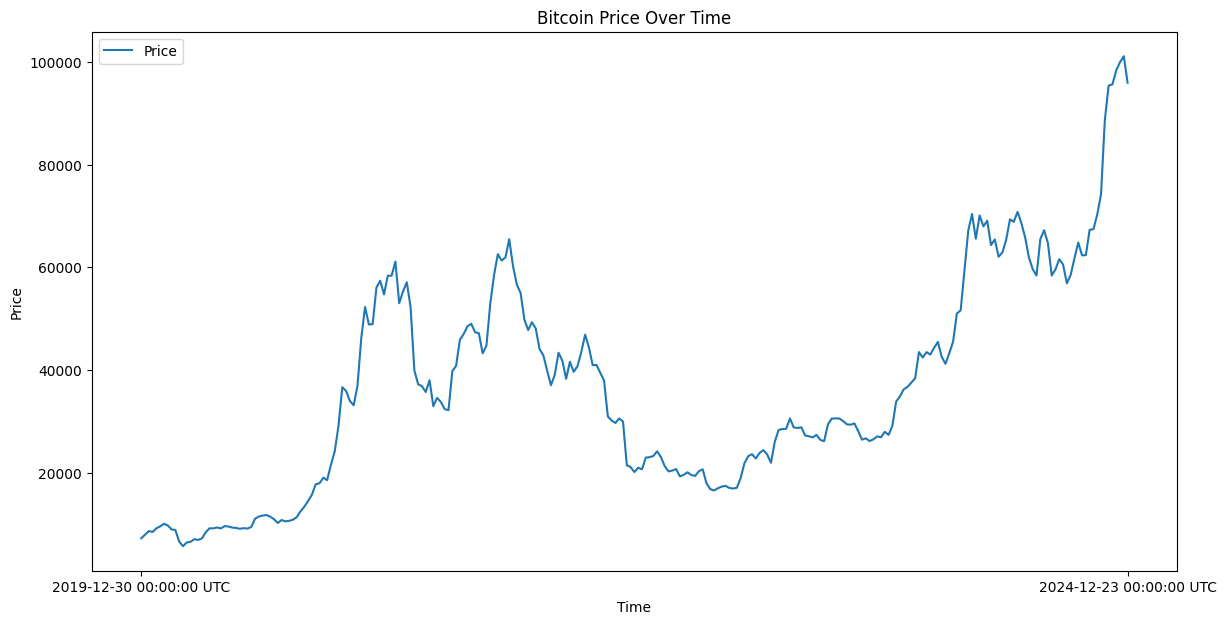

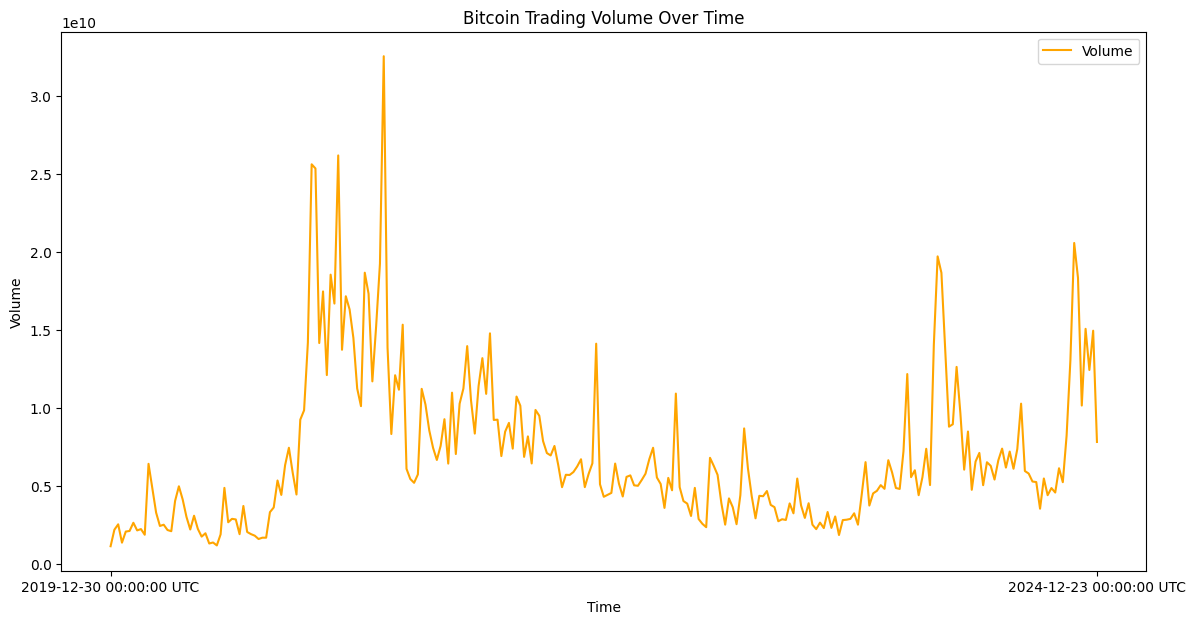

In [155]:
# Display the first few rows of the dataframe
print(price_vol_usd_btc.head())

# Display summary statistics
print(price_vol_usd_btc.describe())

# Check for missing values
print(price_vol_usd_btc.isnull().sum())

# Plot the price over time
plt.figure(figsize=(14, 7))
plt.plot(price_vol_usd_btc['Time'], price_vol_usd_btc['price'], label='Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.xticks([price_vol_usd_btc['Time'].iloc[0], price_vol_usd_btc['Time'].iloc[-1]], [price_vol_usd_btc['Time'].iloc[0], price_vol_usd_btc['Time'].iloc[-1]])
plt.grid(False)
plt.show()

# Plot the volume over time
plt.figure(figsize=(14, 7))
plt.plot(price_vol_usd_btc['Time'], price_vol_usd_btc['volume'], label='Volume', color='orange')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Bitcoin Trading Volume Over Time')
plt.legend()
plt.xticks([price_vol_usd_btc['Time'].iloc[0], price_vol_usd_btc['Time'].iloc[-1]], [price_vol_usd_btc['Time'].iloc[0], price_vol_usd_btc['Time'].iloc[-1]])
plt.grid(False)
plt.show()

The dataset consists of 261 weekly records of Bitcoin prices and trading volumes from December 2019 to December 2024. The average Bitcoin price over this period is approximately $36,382.59, with a standard deviation of $21,078.94, indicating significant price fluctuations. The minimum recorded price is $5,757.42, and the maximum is $101,064.22. The average trading volume is around $6.95 billion, with a standard deviation of $4.93 billion. The dataset has no missing values, ensuring completeness for analysis.



### Google Trends

We normalize the values for the interest in 'bitcoin' the price and trading volume in USD and render it as a line chart.

        Woche  bitcoin  investment  inflation  economy  crypto
0  2019-12-29       11           7          2        5       1
1  2020-01-05       14           9          2        7       2
2  2020-01-12       14           8          2        7       2
3  2020-01-19       12           9          2        7       2
4  2020-01-26       13           8          2        7       2
          bitcoin  investment   inflation     economy      crypto
count  262.000000  262.000000  262.000000  262.000000  262.000000
mean    28.820611    9.202290    4.064885    6.820611    9.908397
std     15.106083    0.914503    1.623459    1.254217    6.484228
min     11.000000    7.000000    2.000000    4.000000    1.000000
25%     19.000000    9.000000    3.000000    6.000000    6.000000
50%     23.000000    9.000000    4.000000    7.000000    8.000000
75%     35.000000   10.000000    5.000000    8.000000   13.000000
max    100.000000   12.000000    9.000000   11.000000   36.000000
Woche         0
bitcoin     

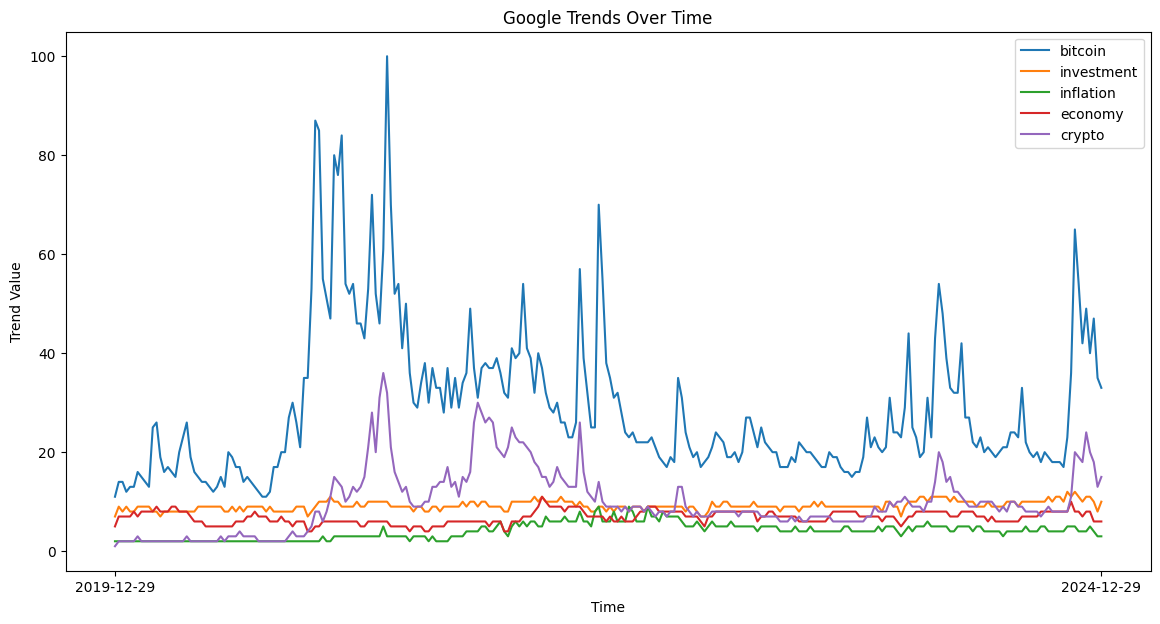

         Woche  bitcoin  investment  inflation  economy  crypto
72  2021-05-16      100          10          3        6      32


In [156]:
# Display the first few rows of the dataframe
print(google_trends.head())

# Display summary statistics
print(google_trends.describe())

# Check for missing values
print(google_trends.isnull().sum())

# Plot the trends over time
plt.figure(figsize=(14, 7))
for column in google_trends.columns[1:]:
    plt.plot(google_trends['Woche'], google_trends[column], label=column)
plt.xlabel('Time')
plt.ylabel('Trend Value')
plt.title('Google Trends Over Time')
plt.legend()
plt.xticks([google_trends['Woche'].iloc[0], google_trends['Woche'].iloc[-1]], [google_trends['Woche'].iloc[0], google_trends['Woche'].iloc[-1]])
plt.grid(False)
plt.show()

# Find the week with the highest value for bitcoin
print(google_trends[google_trends['bitcoin'] == google_trends['bitcoin'].max()])

The dataset consists of 262 weekly records from December 2019 to December 2024, capturing the interest in various financial terms such as 'bitcoin', 'investment', 'inflation', 'economy', and 'crypto' from Google Trends. The 'bitcoin' interest ranges from 11 to 100, with a mean of approximately 28.82 and a standard deviation of 15.11. The 'investment' interest ranges from 7 to 12, with a mean of 9.20 and a standard deviation of 0.91. The 'inflation' interest ranges from 2 to 9, with a mean of 4.06 and a standard deviation of 1.62. The 'economy' interest ranges from 4 to 11, with a mean of 6.82 and a standard deviation of 1.25. The 'crypto' interest ranges from 1 to 36, with a mean of 9.91 and a standard deviation of 6.48. There are no missing values in the dataset.

All values in this dataset are relative to the highest interesst in bitcoin (100 in week 2021-05-16).



## data preprocessing and visual analysis

To use the data, the date columns in the google_trends and price_vol_usd_btc DataFrames are converted to datetime format. A new column year_week is added to both DataFrames, containing the year and week extracted from the date.

The DataFrames are then merged based on the year_week column. After merging, unnecessary columns are dropped, and for better readability the volume column is renamed to volume_usd. Finally, the year_week column is set as the index of the resulting DataFrame.

We than plot an normalized version of the 'bitcoin', 'price' and 'volume_usd' columns to compare them visually.

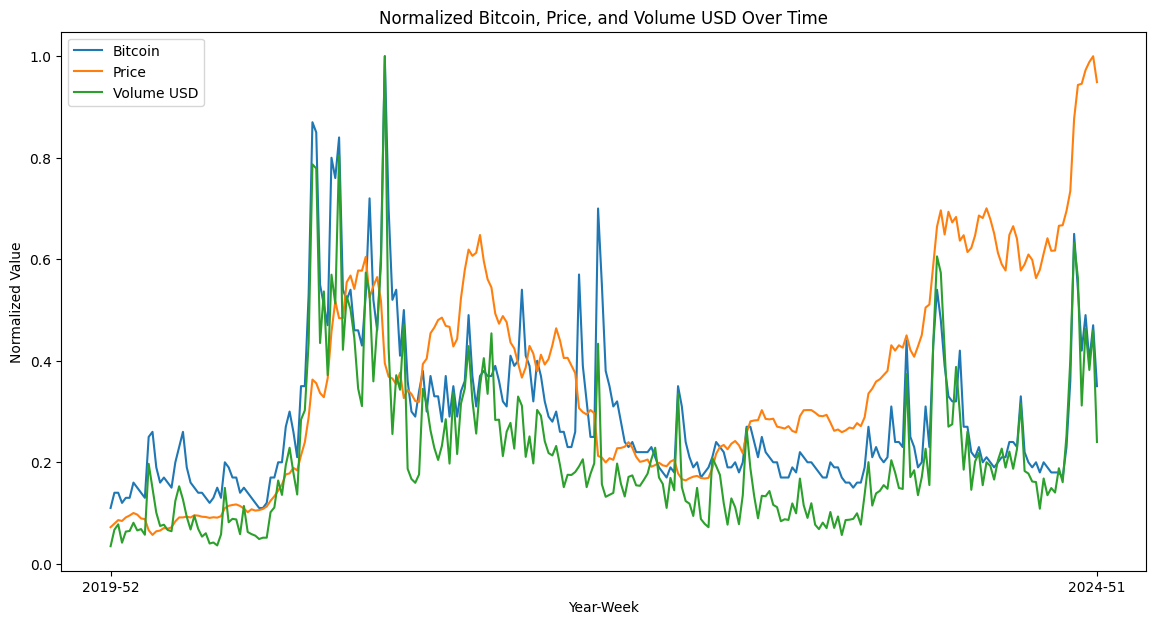

In [157]:
# convert date to datetime
google_trends['date'] = pd.to_datetime(google_trends['Woche'])
price_vol_usd_btc['date'] = pd.to_datetime(price_vol_usd_btc['Time'])

# add a new column with year and week
google_trends['year_week'] = google_trends['date'].dt.strftime('%Y-%U')
price_vol_usd_btc['year_week'] = price_vol_usd_btc['date'].dt.strftime('%Y-%U')

# merge data by year and week
weekly_data = pd.merge(google_trends, price_vol_usd_btc, on='year_week')

weekly_data.drop(columns=['Woche', 'date_x', 'date_y', 'Time'], inplace=True)
weekly_data.rename(columns={'volume': 'volume_usd'}, inplace=True)

weekly_data.set_index('year_week', inplace=True)
# Normalize each column to its highest point
normalized_data = weekly_data[['bitcoin', 'price', 'volume_usd']].apply(lambda x: x / x.max())

# Plot the normalized data
plt.figure(figsize=(14, 7))
plt.plot(normalized_data.index, normalized_data['bitcoin'], label='Bitcoin')
plt.plot(normalized_data.index, normalized_data['price'], label='Price')
plt.plot(normalized_data.index, normalized_data['volume_usd'], label='Volume USD')

plt.xlabel('Year-Week')
plt.ylabel('Normalized Value')
plt.title('Normalized Bitcoin, Price, and Volume USD Over Time')
plt.legend()
plt.xticks([normalized_data.index[0], normalized_data.index[-1]], [normalized_data.index[0], normalized_data.index[-1]])
plt.grid(False)
plt.show()

A first glance shows, that their might be a correlation between the interest for bitcoin and the trading volume. No eyecatching correlation can be seen between the interesst in 'bitcoin' and the price.

Next, we calculate the price difference in percent from one week to the next (bars in blue (positive diff)  and red(negativ diff)) und show the trading volume on top.

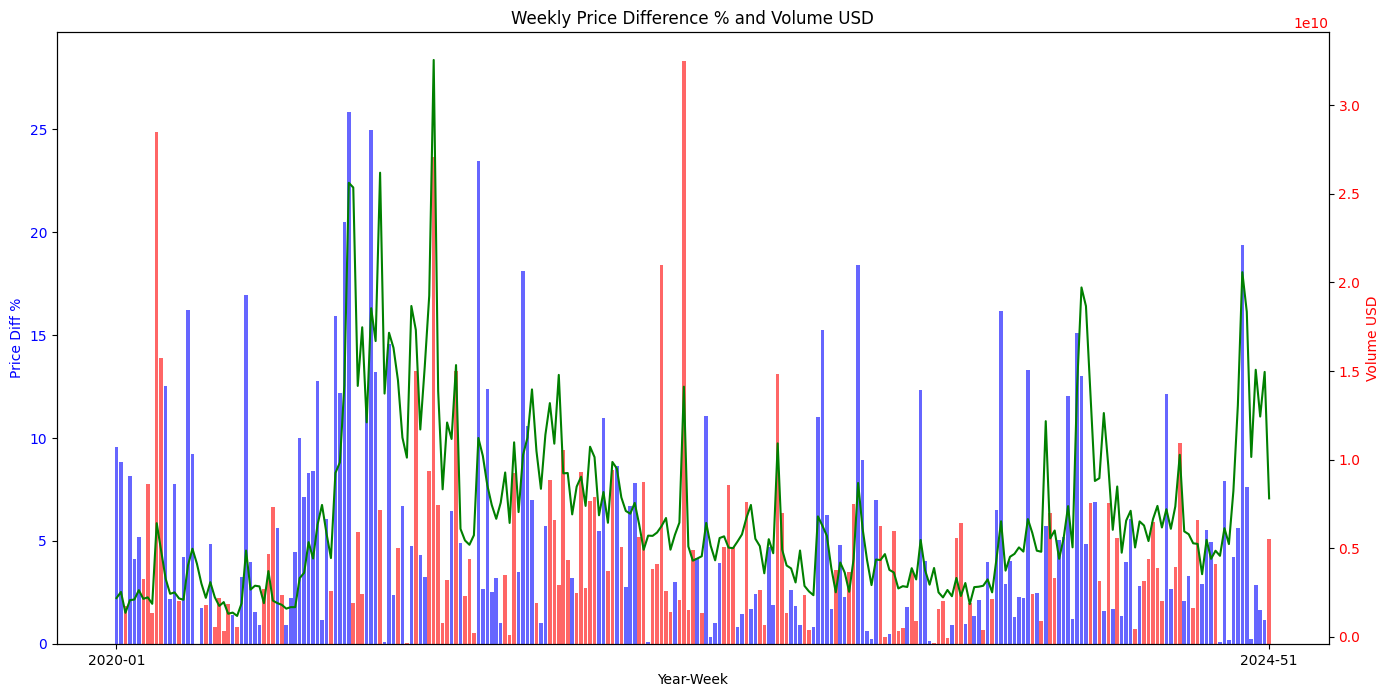

In [158]:
# Calculate the price difference in percent to the previous week
weekly_data['price_diff_pct'] = weekly_data['price'].pct_change() * 100

# Drop the first row as it will have NaN value for price_diff_pct
weekly_data.dropna(subset=['price_diff_pct'], inplace=True)

# Plot the price difference as a bar chart and the volume as a line chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar chart for price difference with absolute values
colors = ['b' if val >= 0 else 'r' for val in weekly_data['price_diff_pct']]
ax1.bar(weekly_data.index, weekly_data['price_diff_pct'].abs(), color=colors, alpha=0.6, label='Price Diff %')
ax1.set_xlabel('Year-Week')
ax1.set_ylabel('Price Diff %', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Line chart for volume
ax2 = ax1.twinx()
ax2.plot(weekly_data.index, weekly_data['volume_usd'], color='g', label='Volume USD')
ax2.set_ylabel('Volume USD', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.xticks([weekly_data.index[0], weekly_data.index[-1]], [weekly_data.index[0], weekly_data.index[-1]])
plt.grid(False)
plt.title('Weekly Price Difference % and Volume USD')
plt.show()

# drop the created column
weekly_data.drop(columns=['price_diff_pct'], inplace=True)

As might be expected, high price changes correspond roughly with high trading volume.

## data preparation for machine learning

After merging the data by the calender week, we have a dataset with the following columns:

In [159]:
# show columns of weekly_data
print(', '.join(weekly_data.columns))

bitcoin, investment, inflation, economy, crypto, price, volume_usd


As we want to predict the price-value of next week **price+1w** using the other provided data from this week and historical data, we create the according colums. We have to remove the first few rows, as we don't have historical data for them and the last row (no prediction value available).

In [160]:
# build up the final data structure

# create columns for historical data
for col in weekly_data.columns:
    weekly_data[f'{col}-1w'] = weekly_data[col].shift(1)
    weekly_data[f'{col}-2w'] = weekly_data[col].shift(2)
    weekly_data[f'{col}-5w'] = weekly_data[col].shift(5)

# create column for target (price in 1 week)
weekly_data['price+1w'] = weekly_data['price'].shift(-1)

# drop rows with NaN (no history for first 5 weeks)
weekly_data = weekly_data.iloc[5:]

# drop last row (no target for last week)
weekly_data = weekly_data.iloc[:-1]

# defragmented copy of the data
weekly_data = weekly_data.copy()

In [161]:
# show columns of weekly_data
print(', '.join(weekly_data.columns))

bitcoin, investment, inflation, economy, crypto, price, volume_usd, bitcoin-1w, bitcoin-2w, bitcoin-5w, investment-1w, investment-2w, investment-5w, inflation-1w, inflation-2w, inflation-5w, economy-1w, economy-2w, economy-5w, crypto-1w, crypto-2w, crypto-5w, price-1w, price-2w, price-5w, volume_usd-1w, volume_usd-2w, volume_usd-5w, price+1w



### Splitting the Data and Training the Model

The dataset `weekly_data` was split into features (`X`) and target (`y`), where the target is the price of Bitcoin one week ahead (`price+1w`). The data was further divided into training and testing sets using an 80-20 split to ensure the model's performance can be evaluated on unseen data. A `RandomForestRegressor` was chosen for training due to its robustness in handling various data types and its ability to capture complex interactions between features. This ensemble method reduces overfitting by averaging multiple decision trees, making it well-suited for predicting Bitcoin prices, which can be influenced by numerous volatile factors.


In [ ]:
# choose the features for the model
features = ['bitcoin', 'investment', 'inflation', 'economy', 'crypto', 'price','volume_usd', 
            'bitcoin-1w', 'bitcoin-2w', 'bitcoin-5w', 
            'investment-1w','investment-2w', 'investment-5w', 
            'inflation-1w', 'inflation-2w','inflation-5w', 
            'economy-1w', 'economy-2w', 'economy-5w', 
            'crypto-1w', 'crypto-2w', 'crypto-5w', 
            'price-1w', 'price-2w', 'price-5w',
            'volume_usd-1w', 'volume_usd-2w', 'volume_usd-5w'
            ]


# Split the data into features and target
X = weekly_data[features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 


# Make predictions
y_pred = model.predict(X_test)

# creating reference variables
best_mape = 1
best_r2 = 0
best_model = model

# Evaluate the model
def evaluate_model_performance(X_test, y_test, model, y_pred, best_performance):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)



    print(f'Mean Absolute Percentage Error: {mape}')
    print(f'R^2 Score: {r2}')

    if mape < best_performance:
        print('New best model found!')
        best_mape = mape
        best_r2 = r2
        best_model = model
        best_X_test = X_test
        best_y_test = y_test
        best_y_pred = y_pred

evaluate_model_performance(X_test, y_test, model, y_pred, best_mape)


Mean Absolute Percentage Error: 0.054718669007315514
R^2 Score: 0.9687472871339848
New best model found!


Mape and the R^2-Score sound promissing.

## Refinement

This was just the first shot. Let's try to optimize the model.

Feature ranking:
1. Feature price (0.9078321384186032)
2. Feature price-1w (0.05790886428772617)
3. Feature price-2w (0.009156222667101945)
4. Feature bitcoin-5w (0.002708160040507904)
5. Feature economy-5w (0.0020663116620728856)
6. Feature volume_usd-1w (0.0020353936132394127)
7. Feature volume_usd (0.0017766159217620964)
8. Feature volume_usd-5w (0.0016813263862449459)
9. Feature price-5w (0.00141631348947163)
10. Feature economy-2w (0.0013138063276186402)
11. Feature inflation (0.0011124016391881068)
12. Feature inflation-5w (0.0010969818893738822)
13. Feature crypto (0.0010941286518877612)
14. Feature investment-2w (0.0009920957235014898)
15. Feature volume_usd-2w (0.0009111435199412218)
16. Feature crypto-5w (0.0008673123021850215)
17. Feature bitcoin-2w (0.0008366764985186152)
18. Feature crypto-2w (0.0007674316417030974)
19. Feature investment (0.0007439782397454094)
20. Feature crypto-1w (0.000739470268024556)
21. Feature inflation-2w (0.0006042418065278217)
22. Feature bitcoi

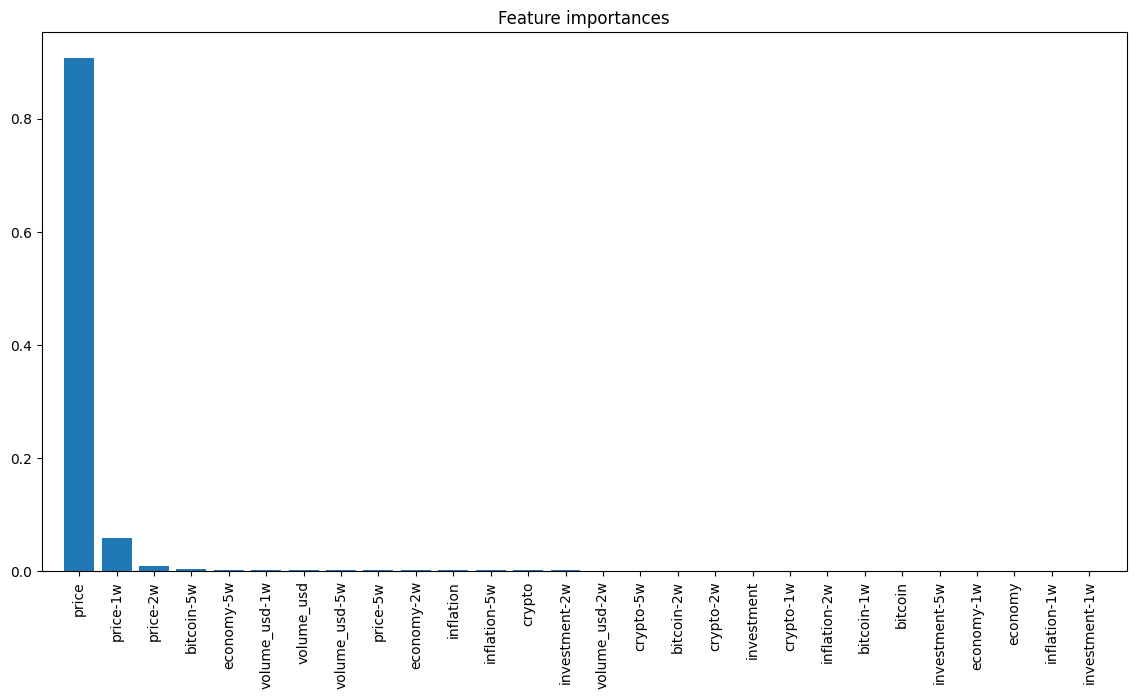

In [163]:
# Feature-Importances extrahieren
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Feature-Importances anzeigen
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {features[indices[f]]} ({importances[indices[f]]})")

# Feature-Importances visualisieren
plt.figure(figsize=(14, 7))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

We see, that the current and historc price (-1w&-2w) significantly influence the decision making. Only at place 4 and 5 do the google trends infos come into play.

In [164]:
# RFE-Objekt erstellen, um die 5 wichtigsten Features zu finden
rfe = RFE(estimator=model, n_features_to_select=5)

# RFE auf die Daten anwenden
rfe.fit(X, y)

# Unterstützungs- und Ranking-Arrays anzeigen
print("Support array (True indicates selected features):")
print(rfe.support_)
print("Ranking of features (1 indicates selected features):")
print(rfe.ranking_)

# Die ausgewählten Features extrahieren
selected_features = np.array(features)[rfe.support_]

# Die ausgewählten Features anzeigen
print("Selected features:")
print(selected_features)



Support array (True indicates selected features):
[False False False False False  True False False False  True False False
 False False False False False False  True False False False  True  True
 False False False False]
Ranking of features (1 indicates selected features):
[15  8 16 24 13  1  2 11 10  1 21 18 20 22 23  9 14 17  1  6 19 12  1  1
  4  3  7  5]
Selected features:
['price' 'bitcoin-5w' 'economy-5w' 'price-1w' 'price-2w']


In [165]:
# train a new model with the selected features
X = weekly_data[selected_features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 


# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



print(f'Mean Absolute Percentage Error: {mape} (Best: {best_mape})')
print(f'R^2 Score: {r2} (Best: {best_r2})')

if mape < best_mape:
    print('New best model found!')
    best_mape = mape
    best_r2 = r2
    best_model = model
    best_X_test = X_test
    best_y_test = y_test
    best_y_pred = y_pred


Mean Absolute Percentage Error: 0.05095984875310116 (Best: 0.054718669007315514)
R^2 Score: 0.9766601374830669 (Best: 0.9687472871339848)
New best model found!


We got better!

But just out of curiosity: what happens, if we don't include the price history to focus more on the google trend data?

In [166]:
# choose the features for the model
features = ['bitcoin', 'investment', 'inflation', 'economy', 'crypto', 
            'price',
            'volume_usd', 
            'bitcoin-1w', 'bitcoin-2w', 'bitcoin-5w', 
            'investment-1w','investment-2w', 'investment-5w', 
            'inflation-1w', 'inflation-2w','inflation-5w', 
            'economy-1w', 'economy-2w', 'economy-5w', 
            'crypto-1w', 'crypto-2w', 'crypto-5w', 
            # 'price-1w', 'price-2w', 'price-5w',
            'volume_usd-1w', 'volume_usd-2w', 'volume_usd-5w'
            ]


# Split the data into features and target
X = weekly_data[features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 


# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape} (Best: {best_mape})')
print(f'R^2 Score: {r2} (Best: {best_r2})')

if mape < best_mape:
    print('New best model found!')
    best_mape = mape
    best_r2 = r2
    best_model = model    
    best_X_test = X_test
    best_y_test = y_test
    best_y_pred = y_pred

Mean Absolute Percentage Error: 0.05445249517799523 (Best: 0.05095984875310116)
R^2 Score: 0.96641846415169 (Best: 0.9766601374830669)


In [167]:
# RFE-Objekt erstellen, um die 5 wichtigsten Features zu finden
rfe = RFE(estimator=model, n_features_to_select=5)

# RFE auf die Daten anwenden
rfe.fit(X, y)

# Unterstützungs- und Ranking-Arrays anzeigen
print("Support array (True indicates selected features):")
print(rfe.support_)
print("Ranking of features (1 indicates selected features):")
print(rfe.ranking_)

# Die ausgewählten Features extrahieren
selected_features = np.array(features)[rfe.support_]

# Die ausgewählten Features anzeigen
print("Selected features:")
print(selected_features)

Support array (True indicates selected features):
[False False False False False  True  True  True False  True False False
 False False False False False False  True False False False False False
 False]
Ranking of features (1 indicates selected features):
[12  9 14 20  6  1  1  1 10  1 17 15 18 21 19  7 11 16  1  2 13  8  3  5
  4]
Selected features:
['price' 'volume_usd' 'bitcoin-1w' 'bitcoin-5w' 'economy-5w']


In [ ]:
# train a new model with the selected features
X = weekly_data[selected_features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 


# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape} (Best: {best_mape})')
print(f'R^2 Score: {r2} (Best: {best_r2})')

if mape < best_mape:
    print('New best model found!')
    best_mape = mape
    best_r2 = r2
    best_model = model    
    best_X_test = X_test
    best_y_test = y_test
    best_y_pred = y_pred


Mean Absolute Percentage Error: 0.055541392627419264 (Best: 0.05095984875310116)
R^2 Score: 0.9688666692640955 (Best: 0.9766601374830669)


Worse, than the first try. so we can conclude, that the price-development and the google trends from 5 weeks prior play a significant role in predicting the price next week.

So let's go back to our best model so far (features including price-history) and find out, if more features are better.

In [169]:
# choose the features for the model
features = ['bitcoin', 'investment', 'inflation', 'economy', 'crypto', 'price','volume_usd', 
            'bitcoin-1w', 'bitcoin-2w', 'bitcoin-5w', 
            'investment-1w','investment-2w', 'investment-5w', 
            'inflation-1w', 'inflation-2w','inflation-5w', 
            'economy-1w', 'economy-2w', 'economy-5w', 
            'crypto-1w', 'crypto-2w', 'crypto-5w', 
            'price-1w', 'price-2w', 'price-5w',
            'volume_usd-1w', 'volume_usd-2w', 'volume_usd-5w'
            ]


# Split the data into features and target
X = weekly_data[features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 # RFE-Objekt erstellen, um die wichtigsten Features zu finden
rfe = RFE(estimator=model, n_features_to_select=6)

# RFE auf die Daten anwenden
rfe.fit(X, y)

# Unterstützungs- und Ranking-Arrays anzeigen
print("Support array (True indicates selected features):")
print(rfe.support_)
print("Ranking of features (1 indicates selected features):")
print(rfe.ranking_)

# Die ausgewählten Features extrahieren
selected_features = np.array(features)[rfe.support_]

# Die ausgewählten Features anzeigen
print("Selected features:")
print(selected_features)

# train a new model with the selected features
X = weekly_data[selected_features]
y = weekly_data['price+1w']



# Split the data into training and testing sets respecting the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

 


# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape} (Best: {best_mape})')
print(f'R^2 Score: {r2} (Best: {best_r2})')

if mape < best_mape:
    print('New best model found!')
    best_mape = mape
    best_r2 = r2
    best_model = model
    best_X_test = X_test
    best_y_test = y_test
    best_y_pred = y_pred


Support array (True indicates selected features):
[False False False False False  True  True False False  True False False
 False False False False False False  True False False False  True  True
 False False False False]
Ranking of features (1 indicates selected features):
[14  7 15 23 12  1  1 10  9  1 20 17 19 21 22  8 13 16  1  5 18 11  1  1
  3  2  6  4]
Selected features:
['price' 'volume_usd' 'bitcoin-5w' 'economy-5w' 'price-1w' 'price-2w']
Mean Absolute Percentage Error: 0.0525951303690407 (Best: 0.05095984875310116)
R^2 Score: 0.9751726427705579 (Best: 0.9766601374830669)


## using the best model for investment

If we use our model to predict the price in one week, we can invest our hard earned money. What would be the outcome?

For this to test, we merge our test-dataframes back together.

In [170]:


# combine X_test and y_test and y_pred
test_results = best_X_test.copy()
test_results = test_results[['price']]
test_results['price+1w'] = best_y_test
test_results['price+1w_pred'] = best_y_pred

# order the rows by year_week
test_results.sort_index(inplace=True)

# create a column that shows the percentage difference between the current week price and the price+1w
test_results['price+1w_diff_pct'] = (test_results['price+1w'] - test_results['price']) / test_results['price'] * 100

# create a column that shows, if the predicted price is higher or lower than the price of the current week
test_results['price+1w_pred_diff'] = test_results['price+1w_pred'] - test_results['price']
test_results['price+1w_pred_diff'] = test_results['price+1w_pred_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

# create a column that shows, if the actual price+1w is higher or lower than the price of the current week
test_results['price+1w_diff'] = test_results['price+1w'] - test_results['price']
test_results['price+1w_diff'] = test_results['price+1w_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

# create a column that shows, if the prediction is correct
test_results['correct'] = test_results['price+1w_diff'] == test_results['price+1w_pred_diff']



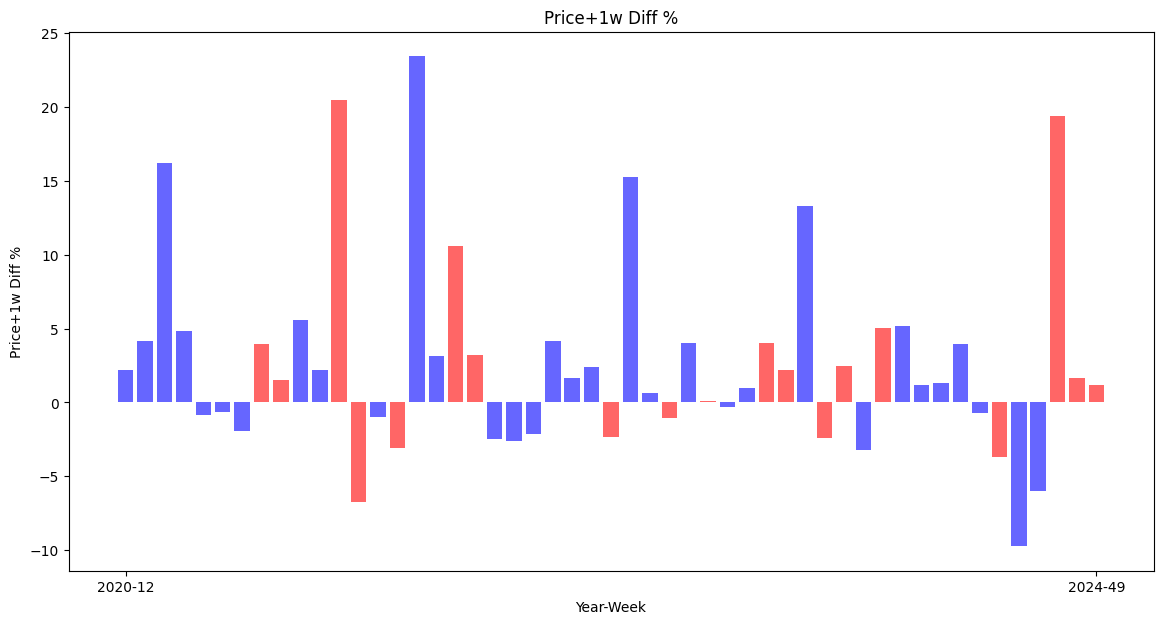

In [171]:
# render a bar chart of the price+1w_diff_pct. The color should be red, if the prediction was wrong, and blue if it was correct
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['r' if val == False else 'b' for val in test_results['correct']]
ax.bar(test_results.index, test_results['price+1w_diff_pct'], color=colors, alpha=0.6)
ax.set_xlabel('Year-Week')
ax.set_ylabel('Price+1w Diff %')
plt.xticks([test_results.index[0], test_results.index[-1]], [test_results.index[0], test_results.index[-1]])
plt.grid(False)
plt.title('Price+1w Diff %')
plt.show()


The bars show the actual percentage differenc of price and price+1w (real prices). If the bar is blue, we predicted the right direction of the price. If the bar is red, the prediction was fundamentaly wrong. We miss-predicted some big price differences, but overall this seems ok. 

So let's see, what happens if we invest some money. If we predict rising prices, we buy Bitcoin. If we predict falling prices, we short Bitcoin and profit from the falling prices. But only, if we are right :). 

In this way we can compute our investment simply by multiplying with the actual price difference (size of the bars) and than adding or subtracting depending if we were right or wrong. If we consistently invest 100$ each week, we can just add the absolut values of all blue-bar-percentages and subtract the red ones.

So lets flip all the correct predicted bars to the positive side and all red ones to the negative side.

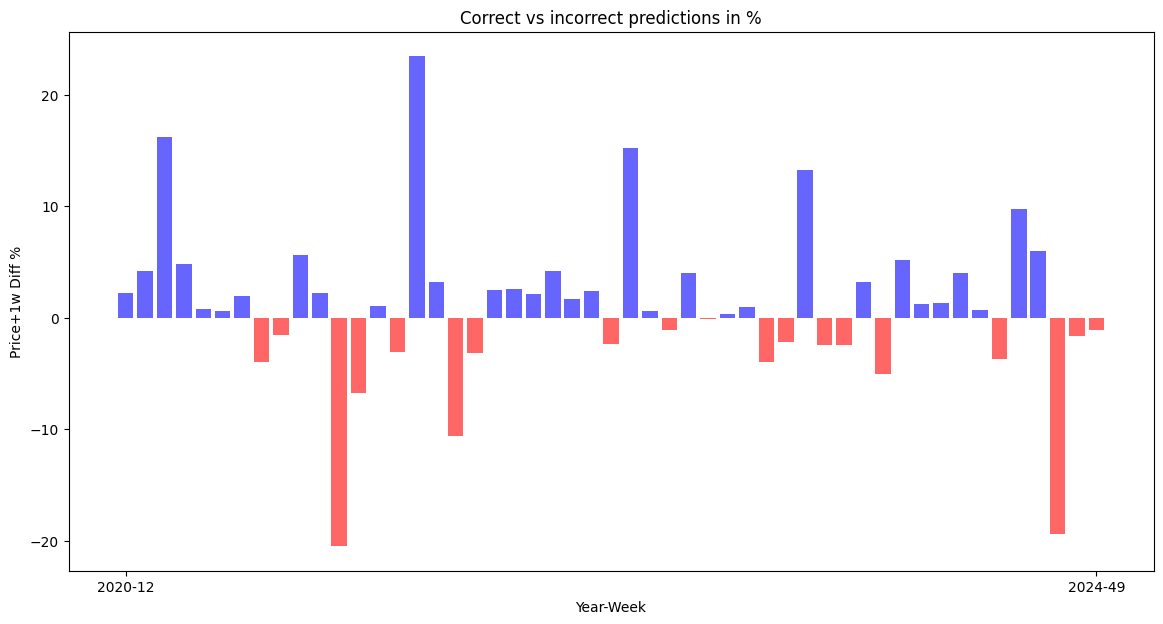

In [172]:
# Flip all correct bars to positive and all incorrect bars to negative
test_results['price+1w_diff_result'] = test_results.apply(lambda x: abs(x['price+1w_diff_pct']) if x['correct'] else -abs(x['price+1w_diff_pct']), axis=1)

# Render a bar chart of the price+1w_diff_result. The color should be red if the prediction was wrong, and blue if it was correct
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['r' if val == False else 'b' for val in test_results['correct']]
ax.bar(test_results.index, test_results['price+1w_diff_result'], color=colors, alpha=0.6)
ax.set_xlabel('Year-Week')
ax.set_ylabel('Price+1w Diff %')
plt.xticks([test_results.index[0], test_results.index[-1]], [test_results.index[0], test_results.index[-1]])
plt.grid(False)
plt.title('Correct vs incorrect predictions in %')

plt.show()

In [173]:
# compute the sum of the price+1w_diff_result column
sum_diff = test_results['price+1w_diff_result'].sum()



And sort the Bars by size. The result of our investment is shown in percent in the top right corner. Not bad!

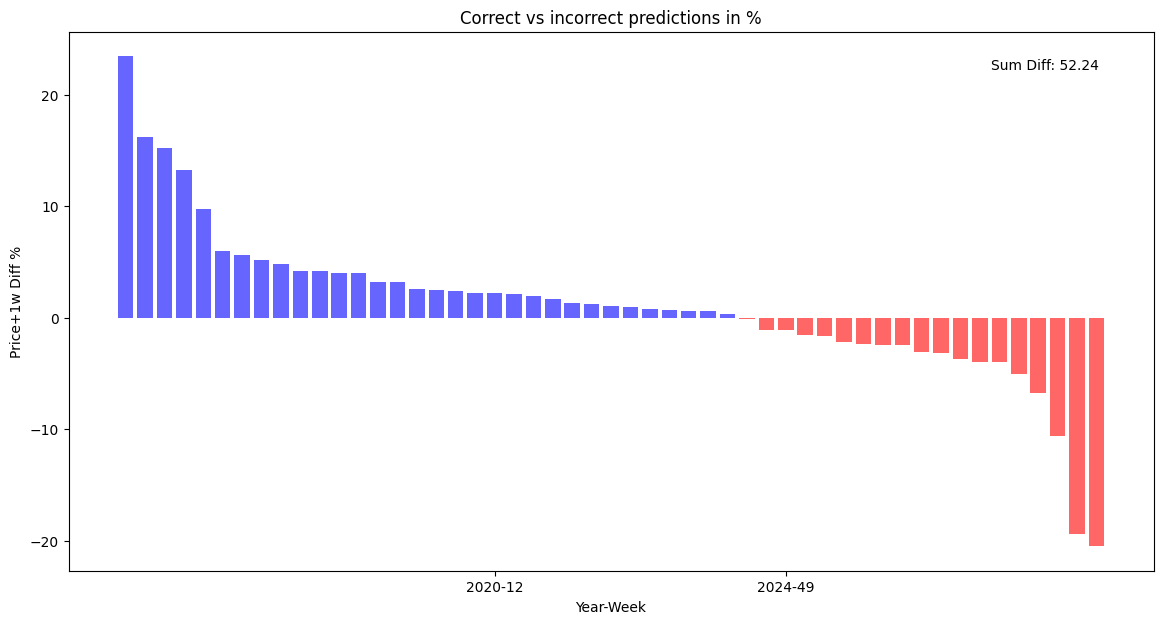

In [174]:
# render a bar chart of the price+1w_diff_result. The color should be red, if the prediction was wrong, and blue if it was correct. order by size
fig, ax = plt.subplots(figsize=(14, 7))
test_results_sorted = test_results.sort_values('price+1w_diff_result', ascending=False)
colors = ['r' if val == False else 'b' for val in test_results_sorted['correct']]
ax.bar(test_results_sorted.index, test_results_sorted['price+1w_diff_result'], color=colors, alpha=0.6)
ax.set_xlabel('Year-Week')
ax.set_ylabel('Price+1w Diff %')
plt.xticks([test_results.index[0], test_results.index[-1]], [test_results.index[0], test_results.index[-1]])
plt.grid(False)
plt.title('Correct vs incorrect predictions in %')

# Add sum_diff to the top right corner
plt.text(0.95, 0.95, f'Sum Diff: {sum_diff:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

plt.show()


In [175]:
print('By following our predicted model we would have gained {:.1f}% over the course of {} weeks'.format(sum_diff, len(test_results)))

By following our predicted model we would have gained 52.2% over the course of 51 weeks
